In [1]:
using StaticArrays

In [2]:
using Plots, LinearAlgebra

In [3]:
import Statistics: mean

In [4]:
using Profile

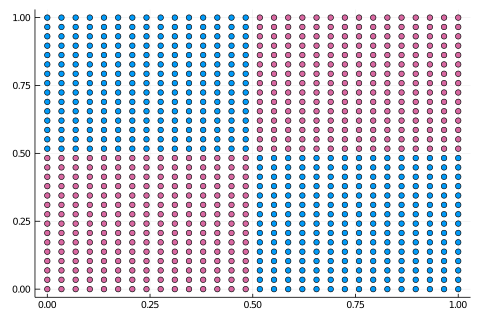

In [5]:
domain = range(0, stop=1, length=30)
dataset = vec([([x1, x2], round(Int64, x1) ⊻ round(Int64, x2)) for x1 in domain, x2 in domain])
scatter(map(x->x[1][1], dataset), map(x->x[1][2], dataset), color=map(x -> x[2][1], dataset), dpi=20, legend=false)

---

# "Almost" Zero-Allocation Neural Network

In [36]:
module ZeroAllocationNN

export ZANN
mutable struct ZANN
    weights :: Vector{Matrix{Float64}}
    biases :: Vector{Vector{Float64}}
    
    weighted_inputs :: Vector{Vector{Float64}}
    activations :: Vector{Vector{Float64}}
        
    nabla_ws :: Vector{Matrix{Float64}}
    nabla_bs :: Vector{Vector{Float64}}
    
    function ZANN(layer_dims)
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(layer_dims[i]))
        end
        return new(
            weights,
            biases,
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims)),
            Vector{Matrix{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1)
        )
    end
end

export predict
function predict(nn::ZANN, x :: Vector{Float64})
    a = x # 1 allocation
    for (w, b) in zip(nn.weights, nn.biases)
        a = w * a # 1 allocation
        @. a = sigma(a + b)
    end
    return a # 1 allocation
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export backprop
function backprop(nn::ZANN, x :: Vector{Float64}, y :: Vector{Float64})
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x
    
    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end
    
    # backward pass
    # BP1 (Output layer error)
    delta :: Vector{Float64} = (nn.activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])
    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = delta
    # BP4 (Cost gradient w.r.t weights)
    nn.nabla_ws[1] = delta * nn.activations[end-1]'
    
    for (i,(w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = delta
        nn.nabla_ws[i+1] = delta * a'
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end



end

import Main.ZeroAllocationNN

println("Network creation")
@time zann = ZeroAllocationNN.ZANN([2,30,20,1]);
println("Prediction")

@time ZeroAllocationNN.predict(zann, randn(2));
# @code_warntype ZeroAllocationNN.predict(zann, randn(2));
println("Backpropagation")
@time ZeroAllocationNN.backprop(zann, randn(2), randn(1));

Network creation


  0.000045 seconds (18 allocations: 7.344 KiB)
Prediction
  0.000017 seconds (4 allocations: 768 bytes)
Backpropagation
  0.000046 seconds (19 allocations: 8.266 KiB)


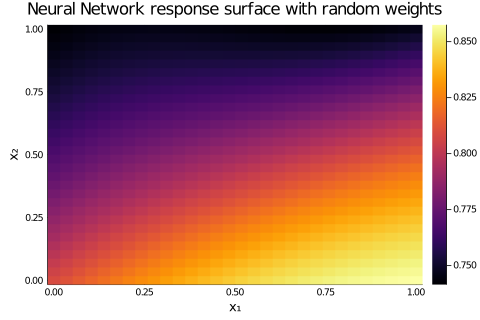

In [37]:
heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface with random weights",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

In [38]:
# epochs = 1_000
# minibatch_size = 900
# eta = 0.05
# @time for epoch in 1:epochs
#     nabla_ws, nabla_bs = ZeroAllocationNN.backprop(zann, Vector(dataset[1][1]), [float(dataset[1][2])])
    
# #     for (x,y) in rand(dataset, minibatch_size)
#     for (x,y) in dataset
#         delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, Vector(x), [float(y)])
#         nabla_ws += delta_nabla_ws
#         nabla_bs += delta_nabla_bs
#     end
    
#     zann.weights -= (eta * nabla_ws / minibatch_size)
#     zann.biases -= (eta * nabla_bs / minibatch_size)
# end

In [39]:
epochs = 1_000
minibatch_size = 900
eta = 0.05
@time for epoch in 1:epochs
    for (x,y) in dataset
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, Vector(x), [float(y)])
        zann.weights -= (eta * delta_nabla_ws)
        zann.biases -= (eta * delta_nabla_bs)
    end
end

 14.545116 seconds (41.79 M allocations: 18.513 GiB, 16.75% gc time)


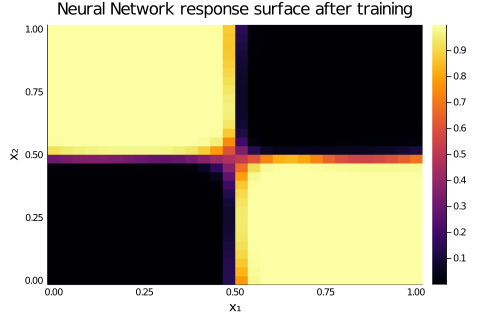

In [40]:
heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, [x1, x2])[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

---
# Flux

In [31]:
using Flux

In [32]:
model = Chain(Dense(2, 30, Flux.σ), Dense(30, 20, Flux.σ), Dense(20, 1, Flux.σ))

loss(x, y) = Flux.Losses.mse(model(x), y)

loss (generic function with 1 method)

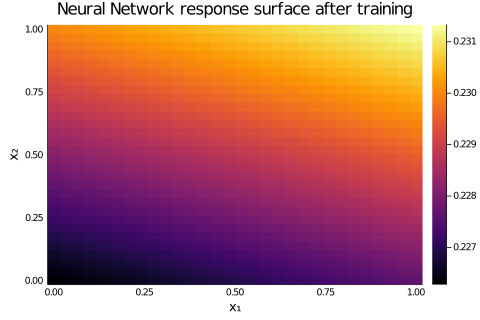

In [33]:
heatmap(
    domain,
    domain,
    (x1, x2) -> model([x1, x2])[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)

In [34]:
@time for _ in  1:1_000
    Flux.train!(loss, Flux.params(model), dataset, Descent(0.05))
end

 44.969855 seconds (139.68 M allocations: 10.040 GiB, 4.69% gc time)


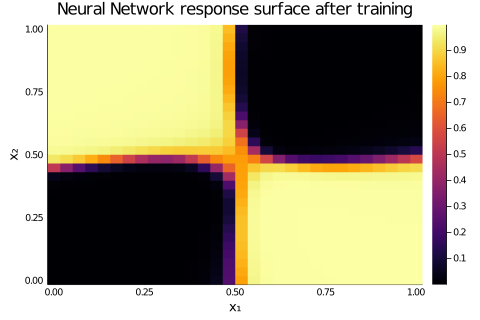

In [35]:
heatmap(
    domain,
    domain,
    (x1, x2) -> model([x1, x2])[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
    dpi=20
)